# Projet_CD2
Projet de Maths du cours Calcul Différentiel II

In [9]:
#Importations
from mpl_toolkits.mplot3d import Axes3D
#import autograd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Amorce
Question : À quelle condition raisonnable portant sur $f(0, 0), f(0, 1)$ et le réel
$c$ est-on certain qu’il existe un $t \in [0, 1]$ tel que $f(0, t) = c$ ? Développer une
fonction qui renvoie un flottant éloigné d’au plus `eps` d’un tel `t` ou `None` si la condition
évoquée ci-dessus n’est pas satisfaite.

Il suffit que la fonction qui a $t$ associe $f(0,t)$ soit continue sur $[0,1]$ (ce qui est le cas car $f$ est continûment différentiable), et que $(f(0,0)-c)(f(0,1)-c) <= 0$ pour appliquer le TVI.
Voir la fonction `find_seed(g, c=0, eps=2**(-26))`



In [6]:
def find_seed(g, c=0, eps=2**(-26)):
    """Methode renvoyant un réel t de [0,1] tq g(t) = c.
    La fonction retourne une valueError si jamais (g(0)-c)(g(1)-c) > 0"""
    if (g(0)-c)*(g(1)-c) > 0:
        raise ValueError("Erreur : aucune garantie qu'un t tel que g(t) = c existe !")
    #On fait de la dichotomie car il faut travailler avec le eps
    return dicho(lambda t : g(t) - c,0,1,eps)

def dicho(g,a,b,eps):
    """Méthode récursive utilisant le principe de la dichotomie pour exploiter le TVI"""
    m = (a+b)/2
    if b-a <= 2*eps:
        return m
    elif g(a)*g(m) <= 0:
        return dicho(g,a,m,eps)
    else:
        return dicho(g,m,b,eps)
    
#Test
print(f"$\pi$ /6 = {find_seed(np.sin, c=1/2)}")

$\pi$ /6 = 0.523598775267601


## Propagation
On souhaite implémenter une fonction dont la signature est :

`def simple_contour(f, c=0.0, delta=0.01):
...
return x, y`


qui renvoie un fragment de ligne de niveau de valeur c de f, sous la forme
de deux tableaux 1d d’abscisses et d’ordonnées de points de cette ligne. Les
points devront être espacés d’approximativement delta. En cas d’impossibilité
de générer un tel fragment deux tableaux vides devront être renvoyés.

### Outils mathématiques à disposition
On commence par mettre en place les différents outils mathématiques dont nous allons avoir besoin

In [13]:
def grad(f):
    """Retourne la fonction grad(f)"""
    h = 10**(-10)
    return lambda x,y : np.array((f(x+h,y)-f(x,y), f(x,y+h)-f(x,y)))/h

def creerPlan(f, x0, y0):
    """Retourne une fonction donnant le plan tangent en x0, y0 de f"""
    gradFEnM = grad(f)(x0,y0)
    return lambda x,y : gradFEnM[0]*(x-x0) + gradFEnM[1]*(y-y0) + f(x0,y0)


### Premiers essais

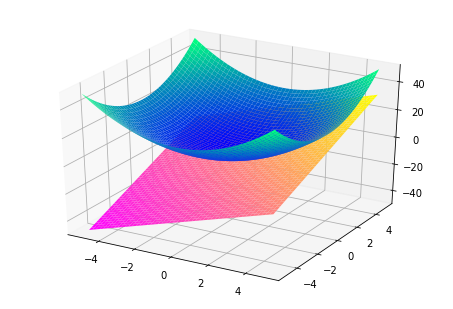

In [14]:
def f(x, y):
    """Fonction f avec laquelle on travaille"""
    return np.power(x,2) + np.power(y,2)

#Création du graphe en 3D
domain_x = np.linspace(-5, 5)   
domain_y = np.linspace(-5, 5)
X, Y = np.meshgrid(domain_x, domain_y)
fig = plt.figure()
ax = Axes3D(fig)

#On trace f
ax.plot_surface(X, Y, f(X, Y), cmap='winter')

#Test de tracé du plan tg en un point (x0,y0)
x0,y0 = 2,2
planEnM = creerPlan(f, x0, y0)
ax.plot_surface(X, Y, planEnM(X,Y), cmap='spring')
